In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [2]:
# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


def f1(p, t):
    # polyval(p, t) evaluates a polynomial of degree N=len(p)
    # i.e. p[0]*t**(N-1) + p[1]*t**(N-2) + ... + p[N-2]*t + p[N-1]
    return jnp.polyval(p, t)


def f2(p, t):
    return p[0] * jnp.sin(p[1] * t)


Ht = f1 * qml.PauliX(0) + f2 * qml.PauliY(1)

In [3]:
p1 = jnp.ones(5)  # parameters for f1
p2 = jnp.array([1.0, jnp.pi])  # parameters for f2
t = 0.5  # some fixed point in time
print(Ht((p1, p2), t))  # order of parameters p1, p2 matters

1.9375 * X(0) + 1.0 * Y(1)


In [4]:
coeffs = [1.0] * 2
coeffs += [lambda p, t: jnp.sin(p[0] * t) + jnp.sin(p[1] * t) for _ in range(3)]
ops = [qml.PauliX(i) @ qml.PauliX(i + 1) for i in range(2)]
ops += [qml.PauliZ(i) for i in range(3)]

Ht = qml.dot(coeffs, ops)

# random coefficients
key = jax.random.PRNGKey(777)
subkeys = jax.random.split(key, 3)  # create list of 3 subkeys
params = [jax.random.uniform(subkeys[i], shape=[2], maxval=5) for i in range(3)]
print(Ht(params, 0.5))

1.0 * (X(0) @ X(1)) + 1.0 * (X(1) @ X(2)) + 1.4456867348869746 * Z(0) + 1.823824746247098 * Z(1) + 1.8206871129031437 * Z(2)


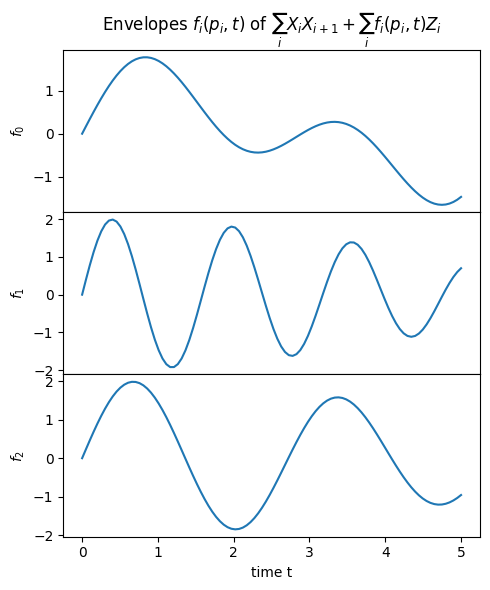

In [5]:
ts = jnp.linspace(0.0, 5.0, 100)
fs = Ht.coeffs_parametrized
ops = Ht.ops_parametrized
n_channels = len(fs)
fig, axs = plt.subplots(nrows=n_channels, figsize=(5, 2 * n_channels), gridspec_kw={"hspace": 0})
for n in range(n_channels):
    ax = axs[n]
    ax.plot(ts, fs[n](params[n], ts))
    ax.set_ylabel(f"$f_{n}$")
axs[0].set_title(f"Envelopes $f_i(p_i, t)$ of $\sum_i X_i X_{{i+1}} + \sum_i f_i(p_i, t) Z_i$")
axs[-1].set_xlabel("time t")
plt.tight_layout()
plt.show()

In [6]:
dev = qml.device("default.qubit", range(4))

ts = jnp.array([0.0, 3.0])
H_obj = sum([qml.PauliZ(i) for i in range(4)])


@jax.jit
@qml.qnode(dev, interface="jax")
def qnode(params):
    qml.evolve(Ht)(params, ts)
    return qml.expval(H_obj)


print(qnode(params))

0.01729011200825281


In [7]:
print(jax.grad(qnode)(params))

[Array([0.16856227, 0.54566685], dtype=float64), Array([-0.03072284,  0.06945661], dtype=float64), Array([-0.12911121, -0.00694704], dtype=float64)]


In [8]:
timespan = 10.0
coeffs = [qml.pulse.pwc(timespan) for _ in range(2)]

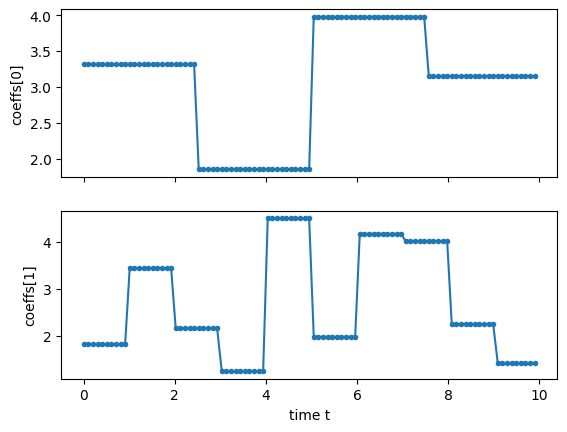

In [9]:
key = jax.random.PRNGKey(777)
subkeys = jax.random.split(key, 2)  # creates a list of two sub-keys
theta0 = jax.random.uniform(subkeys[0], shape=[4], maxval=5)
theta1 = jax.random.uniform(subkeys[1], shape=[10], maxval=5)
theta = [theta0, theta1]

ts = jnp.linspace(0.0, timespan, 100)[:-1]
fig, axs = plt.subplots(nrows=2, sharex=True)
for i in range(2):
    ax = axs[i]
    ax.plot(ts, coeffs[i](theta[i], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [10]:
ops = [qml.PauliX(i) for i in range(2)]
H = qml.pulse.ParametrizedHamiltonian(coeffs, ops)
print(H(theta, 0.5))

3.31518202727953 * X(0) + 1.817160952485034 * X(1)


In [11]:
data = qml.data.load("qchem", molname="HeH+", basis="STO-3G", bondlength=1.5)[0]
H_obj = data.tapered_hamiltonian
H_obj_coeffs, H_obj_ops = H_obj.terms()

# casting the Hamiltonian coefficients to a jax Array
H_obj = qml.Hamiltonian(jnp.array(H_obj_coeffs), H_obj_ops)
E_exact = data.fci_energy
n_wires = len(H_obj.wires)

In [12]:
def a(wires):
    return 0.5 * qml.PauliX(wires) + 0.5j * qml.PauliY(wires)


def ad(wires):
    return 0.5 * qml.PauliX(wires) - 0.5j * qml.PauliY(wires)


omega = 2 * jnp.pi * jnp.array([4.8080, 4.8333])
g = 2 * jnp.pi * jnp.array([0.01831, 0.02131])

H_D = qml.dot(omega, [ad(i) @ a(i) for i in range(n_wires)])
H_D += qml.dot(
    g,
    [ad(i) @ a((i + 1) % n_wires) + ad((i + 1) % n_wires) @ a(i) for i in range(n_wires)],
)

In [13]:
def normalize(x):
    """Differentiable normalization to +/- 1 outputs (shifted sigmoid)"""
    return (1 - jnp.exp(-x)) / (1 + jnp.exp(-x))


# Because ParametrizedHamiltonian expects each callable function to have the signature
# f(p, t) but we have additional parameters it depends on, we create a wrapper function
# that constructs the callables with the appropriate parameters imprinted on them
def drive_field(T, omega, sign=1.0):
    def wrapped(p, t):
        # The first len(p)-1 values of the trainable params p characterize the pwc function
        amp = qml.pulse.pwc(T)(p[:-1], t)
        # The amplitude is normalized to maximally reach +/-20MHz (0.02GHz)
        # amp = 0.02 * normalize(amp)
        amp = 0.1 * normalize(amp)

        # The last value of the trainable params p provides the drive frequency deviation
        # We normalize as the difference to drive can maximally be +/-1 GHz
        d_angle = normalize(p[-1])
        phase = jnp.exp(sign * 1j * (omega + d_angle) * t)
        return amp * phase

    return wrapped


duration = 15.0

fs = [drive_field(duration, omega[i], 1.0) for i in range(n_wires)]
fs += [drive_field(duration, omega[i], -1.0) for i in range(n_wires)]
ops = [a(i) for i in range(n_wires)]
ops += [ad(i) for i in range(n_wires)]

H_C = qml.dot(fs, ops)

In [14]:
H_pulse = H_D + H_C

In [15]:
dev = qml.device("default.qubit", wires=range(n_wires))

@qml.qnode(dev, interface="jax")
def qnode(theta, t=duration):
    qml.BasisState(jnp.array(data.tapered_hf_state), wires=H_obj.wires)
    qml.evolve(H_pulse)(params=(*theta, *theta), t=t)
    return qml.expval(H_obj)


value_and_grad = jax.jit(jax.value_and_grad(qnode))

In [16]:
t_bins = 100  # number of time bins

key = jax.random.PRNGKey(999)
theta = 0.9 * jax.random.uniform(key, shape=jnp.array([n_wires, t_bins + 1]))

import optax
from datetime import datetime

n_epochs = 60

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
schedule0 = optax.constant_schedule(1e-1)
schedule1 = optax.constant_schedule(5e-1)
schedule = optax.join_schedules([schedule0, schedule1], [10])
optimizer = optax.adam(learning_rate=schedule)
opt_state = optimizer.init(theta)

energy = np.zeros(n_epochs + 1)
energy[0] = qnode(theta)
gradients = np.zeros(n_epochs)

## Compile the evaluation and gradient function and report compilation time
time0 = datetime.now()
_ = value_and_grad(theta)
time1 = datetime.now()
print(f"grad and val compilation time: {time1 - time0}")

## Optimization loop
for n in range(n_epochs):
    val, grad_circuit = value_and_grad(theta)
    updates, opt_state = optimizer.update(grad_circuit, opt_state)
    theta = optax.apply_updates(theta, updates)

    energy[n + 1] = val
    gradients[n] = np.mean(np.abs(grad_circuit))

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-E_exact}")
        print(f"mean grad: {gradients[n]}")

grad and val compilation time: 0:00:02.063967
1 / 60; energy discrepancy: 0.03667421482599931
mean grad: 0.0016921640128890944
11 / 60; energy discrepancy: 0.002225213518906255
mean grad: 0.00015813347109100065
21 / 60; energy discrepancy: 0.0022833380322659913
mean grad: 0.00029248478006632607
31 / 60; energy discrepancy: 0.0006175885447858853
mean grad: 0.00018258648766442728
41 / 60; energy discrepancy: 0.00031335858152647944
mean grad: 6.701545003040244e-05
51 / 60; energy discrepancy: 0.0001556933947806094
mean grad: 6.865030502082762e-05


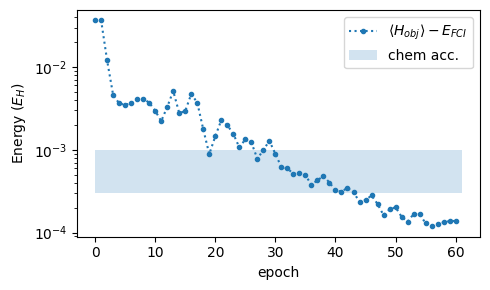

In [17]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = np.array(energy) - E_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{{FCI}}$")
ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

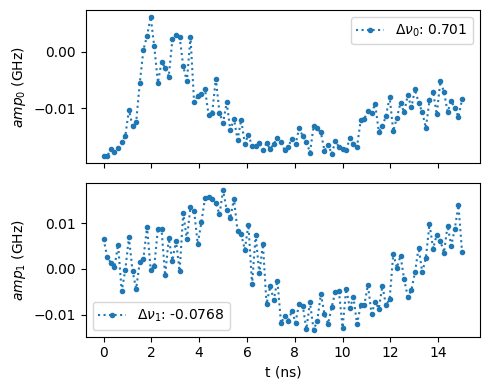

In [18]:
n_channels = n_wires
ts = jnp.linspace(0, duration, t_bins)
fig, axs = plt.subplots(nrows=n_channels, figsize=(5, 2 * n_channels), sharex=True)
for n in range(n_channels):
    ax = axs[n]
    label = f"$\\Delta \\nu_{n}$: {normalize(theta[n][-1]):.3}"
    ax.plot(ts, 0.02 * normalize(theta[n][:-1]), ".:", label=label)
    ax.set_ylabel(f"$amp_{n}$ (GHz)")
    ax.legend()
ax.set_xlabel("t (ns)")

plt.tight_layout()
plt.show()